
 # **Individual Assignment** 
##Real or Not? NLP with Disaster Tweets##


This particular challenge is perfect for data scientists looking to get started with Natural Language Processing. 
The challenge propose a binary text classification task: we have to decide whether a tweet is talking about an actual disaster or not.
The challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t, accessing to a dataset of 10,000 tweets that were hand classified. 



## **The Dataset**

The dataset to be used in this competition are CSV files, namely: `train.csv` - the training set, and `test.csv` - the test set which contains following columns:

- `id`: a unique identifier for each tweet
- `text`: the text of the tweet
- `location`: the location the tweet was sent from (may be blank)
- `keyword`: a particular keyword from the tweet (may be blank)
- `target`: in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)



## **Getting started**

The majority of data science work often revolves around pre-processing data, and making sure it's ready for analysis.

In [1]:
#!pip install sklearn_crfsuite
#!pip install missingno
#!pip install eli5
#!pip install altair
#!pip install gensim
#!pip install wordcloud

In [2]:
# Import libraries

#Basic libraries for Python
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings

#NLP required libraries
import nltk
import sklearn_crfsuite
import eli5
from sklearn import metrics
from sklearn import pipeline
from string import punctuation

from sklearn.metrics import f1_score

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.tree import *
from nltk.draw import tree
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer as TfidV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from collections import Counter

from gensim.models.word2vec import Word2Vec
from gensim.models.tfidfmodel import TfidfModel

#nltk.download('punkt')
#!pip install pyspellchecker
#!pip install emoji
#nltk.download('stopwords')

Using TensorFlow backend.
unable to import 'smart_open.gcs', disabling that module


In [3]:
# Read in the dataset
train = pd.read_csv('train.csv', index_col = False)
test = pd.read_csv('test.csv', index_col = False)

In [4]:
print('Training Set Shape = {}'.format(train.shape))

Training Set Shape = (7613, 5)


In [5]:
# Print the header of the train DataFrame
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Let's look at our data, what kind of tweet is classified as disaster

In [6]:
train.loc[train["target"] == 1].text[1]

'Forest fire near La Ronge Sask. Canada'

In [7]:
print('Test Set Shape = {}'.format(test.shape))

Test Set Shape = (3263, 4)


In [8]:
# Print info of train DataFrame
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Data type problems

Printing the data types confirms that `text`, `location` and `keyword` need to be converted to `string`

## Baseline NLP model with __text__ column

In [9]:
# Import the necessary modules
from sklearn.model_selection import train_test_split

# Create a series to store the labels: y
X = train["text"]
y = train["target"]

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

In [10]:
# Training Naive Bayes (NB) classifier on training data.
from sklearn.naive_bayes import MultinomialNB

text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
text_clf = text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)

### Pipeline with CountVectorizer + TfIdf + Model

The purpose of a Pipeline is to chain together multiple estimators representing a fixed sequence of steps into a single unit. All estimators in the pipeline...

In [11]:
results_df = pd.DataFrame(columns=['Model', 'Approach', 'F1 Score'])
results_df.loc[len(results_df)] = ['Multinomial NB', 'Baseline', f1_score(predicted, y_test)]
results_df

,Model,Approach,F1 Score
0,Multinomial NB,Baseline,0.713514


Without any data cleaning, only machine learning model is applied through text vectorization and tf-idf transformation, 71% F1-score is obtained. There is a lot to do to improve this score yet, which is the objective of this practice assignment.

## Preprocessing

All the work, explanations, motivations and analysis have to be focused on the NLP aspects. In this sense I would like to see the different ideas and methodologies that we explain in class, properly applied: Data Cleaning, POS Tagging, Dependency Parsing, N-grams, Text classification ideas...

### Dealing with Hashtags
A hashtag is a word or an un-spaced phrase prefixed with the hash symbol (#). These are used to both naming subjects and phrases that are currently in trending topics. For example, #iPad, #news

In [12]:
hash_regex = re.compile(r"#(\w+)")
def hash_repl(match):
	return '__HASH_'+match.group(1).upper()

### User Names
Every Twitter user has a unique username. Any thing directed towards that user can be indicated be writing their username preceded by ‘@’. Thus, these are like proper nouns. For example, @Apple

In [13]:
user_regex = re.compile(r"@(\w+)")
def user_repl(match):
	return '__user_'+match.group(1).upper()

### URLs
Users often share hyperlinks in their tweets. Twitter shortens them using its in-house URL shortening service, like http://t.co/FCWXoUd8 - such links also enables Twitter to alert users if the link leads out of its domain. From the point of view of text classification, a particular URL is not important. However, presence of a URL can be an important feature. Regular expression for detecting a URL is fairly complex because of different types of URLs that can be there, but because of Twitter’s shortening service, we can use a relatively simple regular expression.

In [14]:
url_regex = re.compile(r"(http|https|ftp)://[a-zA-Z0-9\./]+")
def url_repl(match):
	return '__URL_'

### Punctuations
Although not all Punctuations are important from the point of view of classification but some of these, like question mark, exclamation mark can also provide information about the sentiments of the text. We replace every word boundary by a list of relevant punctuations present at that point.

In [15]:
# Spliting by word boundaries
word_bound_regex = re.compile(r"\W+")

# Punctuations
punctuations = \
	[	#('',		['.', ] )	,\
		#('',		[',', ] )	,\
		#('',		['\'', '\"', ] )	,\
		('__PUNC_EXCL',		['!', '¡', ] )	,\
		('__PUNC_QUES',		['?', '¿', ] )	,\
		('__PUNC_ELLP',		['...', '…', ] )	,\
	]

#For punctuation replacement
def punctuations_repl(match):
	text = match.group(0)
	repl = []
	for (key, parr) in punctuations :
		for punc in parr :
			if punc in text:
				repl.append(key)
	if( len(repl)>0 ) :
		return ' '+' '.join(repl)+' '
	else :
		return ' '

### Emoticons and Emojis

Use of emoticons is very prevalent throughout the web, more so on micro-blogging sites. We identify the following emoticons and replace them with a single word. Note that, emoticons are the typographis ones as differ from emojis. 

In [28]:
# Emoticons
emoticons = \
	[	('__EMOT_SMILEY',	[':-)', ':)', '(:', '(-:', ] )	,\
		('__EMOT_LAUGH',		[':-D', ':D', 'X-D', 'XD', 'xD', ] )	,\
		('__EMOT_LOVE',		['<3', ':\*', ] )	,\
		('__EMOT_WINK',		[';-)', ';)', ';-D', ';D', '(;', '(-;', ] )	,\
		('__EMOT_FROWN',		[':-(', ':(', '(:', '(-:', ] )	,\
		('__EMOT_CRY',		[':,(', ':\'(', ':"(', ':(('] )	,\
	]
    
def escape_paren(arr):
	return [text.replace(')', '[)}\]]').replace('(', '[({\[]') for text in arr]

def regex_union(arr):
	return '(' + '|'.join( arr ) + ')'

emoticons_regex = [ (repl, re.compile(regex_union(escape_paren(regx))) ) for (repl, regx) in emoticons ]

# Emojis
# from emoji library, we will use demojize() function

### Repetitions
People often use repeating characters while using colloquial language, like "I’m in a hurrryyyyy", "We won, yaaayyyyy!" As our final pre-processing step, we replace characters repeating more than twice as two characters.

In [17]:
# Repeating words like hurrrryyyyyy
rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE);
def rpt_repl(match):
	return match.group(1)+match.group(1)

### Stemming
We will now stemmize the words in the tweets by applying the Porter Stemmer seen in class. This stemmer was very widely used and became and remains the de facto standard algorithm used for English stemming. It offers excellent trade-off between speed, readability, and accuracy.

NLTK has its own implementation of the stemmer

### Lemmatization

The difference between stemming and lemmatization is, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.

In [18]:
import emoji
# Wrapper function that encloses all the processing procedures
def processAll(text):

    # remove usernames:         text = re.sub('@[^\s]+', '', text)
    # remove only hasgtag sign: text = re.sub(r'#([^\s]+)', r'\1', text) 
    # convert emojis to text
    text = emoji.demojize(text)
    # apply functions defined above
    text = re.sub( hash_regex, hash_repl, text )
    text = re.sub( user_regex, user_repl, text)
    text = re.sub( url_regex, ' __URL ', text )

    for (repl, regx) in emoticons_regex :
        text = re.sub(regx, ' '+repl+' ', text)
      
    text = text.replace('\'','')
    
    text = re.sub( word_bound_regex , punctuations_repl, text )
    text = re.sub( rpt_regex, rpt_repl, text )

    words = text.split()

    # eliminate words shorter than 3 chars
    text = [word if(word[0:2]=='__') else word.lower() for word in text.split() if len(word) >= 3]
    # lemmatize
    lemmatizer=WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w) for w in text]
    # stemming
    stemmer = nltk.stem.PorterStemmer()
    text = [stemmer.stem(w) for w in text]                
    
    return(" ".join(text))

To obtain a new column in our dataframe with the processed text

In [19]:
train['processed_tweet'] = train.text.apply(processAll)
train['processed_tweet'].head(11)

0     our deed are the reason thi __hash_earthquak m...
1                     forest fire near rong sask canada
2     all resid ask shelter place are be notifi offi...
3     peopl receiv __hash_wildfir evacu order califo...
4     just got sent thi photo from rubi __hash_alask...
5     __hash_rockyfir updat california hwi close bot...
6     __hash_flood __hash_disast heavi rain caus fla...
7     top the hill and can see fire the wood __punc_...
8     there emerg evacu happen now the build across ...
9     afraid that the tornado come our area __punc_ellp
10               three peopl die from the heat wave far
Name: processed_tweet, dtype: object

In [20]:
X = train["processed_tweet"]
y = train["target"]

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
text_clf = text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)

results_df.loc[len(results_df)] = ['Multinomial NB', 'Baseline with Processed Tweet', f1_score(predicted, y_test)]
results_df

,Model,Approach,F1 Score
0,Multinomial NB,Baseline,0.713514
1,Multinomial NB,Baseline with Processed Tweet,0.717785


### Stopwords

Stop words are the most common words in a language like “the”, “a”, “at”, “for”, “above”, “on”, “is”, “all”. These words do not provide any meaning and are usually removed from texts. We can remove these stop words using nltk library


In [21]:
# Let's see the entire tweet
tokens = word_tokenize(train.text[2])
print(tokens)

['All', 'residents', 'asked', 'to', "'shelter", 'in', 'place', "'", 'are', 'being', 'notified', 'by', 'officers', '.', 'No', 'other', 'evacuation', 'or', 'shelter', 'in', 'place', 'orders', 'are', 'expected']


In [22]:
# The same tweet from which stopwords are excluded:
stop_words = set(stopwords.words("english"))
tokens = [w for w in tokens if not w in stop_words]
print(tokens)           

['All', 'residents', 'asked', "'shelter", 'place', "'", 'notified', 'officers', '.', 'No', 'evacuation', 'shelter', 'place', 'orders', 'expected']


### Further Text Pre Processing

* Negations to Antonyms
* ...

In [23]:
from nltk.corpus import wordnet
def convert_to_antonym(sentence):
    words = nltk.word_tokenize(sentence)
    new_words = []
    temp_word = ''
    for word in words:
        antonyms = []
        if word == 'not':
            temp_word = 'not_'
        elif temp_word == 'not_':
            for syn in wordnet.synsets(word):
                for s in syn.lemmas():
                    for a in s.antonyms():
                        antonyms.append(a.name())
            if len(antonyms) >= 1:
                word = antonyms[0]
            else:
                word = temp_word + word # when antonym is not found, it will
                                    # remain not_happy
            
            temp_word = ''
        if word != 'not':
            new_words.append(word)
    return ' '.join(new_words)

In [24]:
train['processed_text_wo_ant'] = train['processed_tweet'].apply(lambda x: convert_to_antonym(x))
train['processed_text_wo_ant'].head()

0    our deed are the reason thi __hash_earthquak m...
1                    forest fire near rong sask canada
2    all resid ask shelter place are be notifi offi...
3    peopl receiv __hash_wildfir evacu order califo...
4    just got sent thi photo from rubi __hash_alask...
Name: processed_text_wo_ant, dtype: object

Let's modify pipeline by dealing with __stop words__, fitting the model on new text field. This improves the score slightly.

In [25]:
X = train["processed_text_wo_ant"]
y = train["target"]

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')), 
                    ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
text_clf = text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)

results_df.loc[len(results_df)] = ['Multinomial NB', 'Extra Processed Tweet', f1_score(predicted, y_test)]
results_df

,Model,Approach,F1 Score
0,Multinomial NB,Baseline,0.713514
1,Multinomial NB,Baseline with Processed Tweet,0.717785
2,Multinomial NB,Extra Processed Tweet,0.731205


So far, thanks to the __data cleaning__ we leveraged the score by around 4%.

### SVM

SVM seems to outperform Multinomial NB model.

In [26]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
from sklearn import svm
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

text_clf_svm = Pipeline([('vect', CountVectorizer(stop_words='english')), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SVM)])

text_clf_svm = text_clf_svm.fit(X_train, y_train)
predicted_svm = text_clf_svm.predict(X_test)

results_df.loc[len(results_df)] = ['Support Vector Machine', 'Extra Processed Tweets', f1_score(predicted_svm, y_test)]
results_df

,Model,Approach,F1 Score
0,Multinomial NB,Baseline,0.713514
1,Multinomial NB,Baseline with Processed Tweet,0.717785
2,Multinomial NB,Extra Processed Tweet,0.731205
3,Support Vector Machine,Extra Processed Tweets,0.750730


## **Stochastic Gradient Descent**

In [27]:
from sklearn.linear_model import SGDClassifier

text_clf_sgd = Pipeline([('vect', CountVectorizer(stop_words='english')), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, random_state=42))])

text_clf_sgd = text_clf_sgd.fit(X_train, y_train)

predicted = text_clf_sgd.predict(X_test)

results_df.loc[len(results_df)] = ['Stochastic Gradient Descent', 'Fully Cleaned Test', f1_score(predicted, y_test)]
results_df

,Model,Approach,F1 Score
0,Multinomial NB,Baseline,0.713514
1,Multinomial NB,Baseline with Processed Tweet,0.717785
2,Multinomial NB,Extra Processed Tweet,0.731205
3,Support Vector Machine,Extra Processed Tweets,0.750730
4,Stochastic Gradient Descent,Fully Cleaned Test,0.682353


Let's test our model and see how well it does on the training data. For this we'll use cross-validation - where we train on a portion of the known data, then validate it with the rest. If we do this several times (with different portions) we can get a good idea for how a particular model or method performs.

The metric for this competition is F1, so let's use that here.

Algorithms to be applied are: NB, MaxEnt, SVM, RF, Deep Learning

### Random Forest

In [610]:
#########RandomForestClassifier
# Fitting classifier to the Training set

text_clf_rfc = Pipeline([('vect', CountVectorizer(stop_words='english')), ('tfidf', TfidfTransfo
rmer()),
                         ('clf-rfc', RFC)])
 t xt_clf_rfc = text_clf_rfc.fit(X_train, y_train)
predicted_ ('tfidf', TfidfTransformer()),st)

results_df.loc[len(results_df)] = ['Random Forest', 'Fully Cleaned Test', f1_score(predicted_rfc, y_test)]
results_df

SyntaxError: invalid syntax (<ipython-input-610-f60e8b41ae6d>, line 5)

In [578]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

# Fitting classifier to the Training set
text_clf_lr = Pipeline([('vect', CountVectorizer(stop_words='english')), ('tfidf', TfidfTransformer()),
                         ('clf-logreg', LogisticRegression(random_state=0))])

text_clf_lr = text_clf_lr.fit(X_train, y_train)
predicted_lr = text_clf_lr.predict(X_test)

results_df.loc[len(results_df)] = ['Logistic Regression', 'Fully Cleaned Test', f1_score(predicted_lr, y_test)]
results_df

,Model,Approach,F1 Score
0,Multinomial NB,Baseline,0.718085
1,Multinomial NB,Extra Processed Tweet,0.730551
2,Support Vector Machine,Extra Processed Tweets,0.750730
3,Stochastic Gradient Descent,Fully Cleaned Test,0.683473
4,Multinomial NB,Baseline with Processed Tweet,0.718085
5,Logistic Regression,Fully Cleaned Test,0.737425
6,Multinomial NB,Extra Processed Tweet,0.730551
7,Support Vector Machine,Extra Processed Tweets,0.750730
8,Stochastic Gradient Descent,Fully Cleaned Test,0.683473
9,Logistic Regression,Fully Cleaned Test,0.741596


### Deep Learning

### Grid Search

In [461]:
# Here, we are creating a list of parameters for which we would like to do performance tuning. 
# All the parameters name start with the classifier name (remember the arbitrary name we gave). 
# E.g. vect__ngram_range; here we are telling to use unigram and bigrams and choose the one which is optimal.

from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3)}

In [462]:
# Next, we create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)

In [463]:
gs_clf.best_params_
# and the corresponding parameters are {‘clf__alpha’: 0.01, ‘tfidf__use_idf’: True, ‘vect__ngram_range’: (1, 2)}.

{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}

In [464]:
gs_clf.best_score_

0.7762745098039214

#### For SVM

In [465]:
# Similarly doing grid search for SVM
from sklearn.model_selection import GridSearchCV
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False),'clf-svm__alpha': (1e-2, 1e-3)}

gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X_train, y_train)

gs_clf_svm.best_params_

ValueError: Invalid parameter alpha for estimator SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [63]:
gs_clf_svm.best_score_

0.7894117647058824

In [64]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect), ('tfidf', TfidfTransformer()), 
                             ('mnb', MultinomialNB(fit_prior=False))])

text_mnb_stemmed = text_mnb_stemmed.fit(X_train, y_train)

predicted_mnb_stemmed = text_mnb_stemmed.predict(X_test)

np.mean(predicted_mnb_stemmed == y_test)

0.7843215280541186

## **Cleaning data** 

## **Diagnosing data cleaning problems using simple `pandas` and visualizations** 

## *__Word Cloud__*

To represent word usage in a document by resizing individual words proportionally to its frequency, and then presenting them in random arrangement.


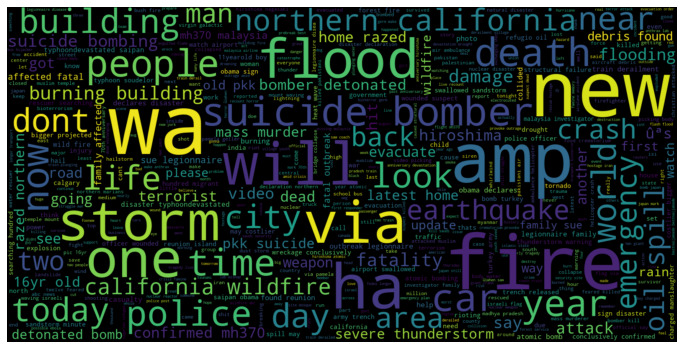

In [490]:
# Wrapper function that encloses to highlight meaningful words to be shown in wordCloud
import string

def processforCloud(text):

    text = [char for char in text if char not in string.punctuation]
    text = ''.join(text)
    text = re.sub('@[^\s]+', '', text)
    text = re.sub(r'#([^\s]+)', r'\1', text) 
    text = re.sub( url_regex, '',text )
    text = text.replace('\'','')
    text = re.sub( word_bound_regex , punctuations_repl, text )
    text = re.sub( rpt_regex, rpt_repl, text )
    words = text.split()
    # eliminate words shorter than 3 chars
    text = [word if(word[0:2]=='__') else word.lower() for word in text.split() if len(word) >= 3]
    # lemmatize
    lemmatizer=WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w) for w in text]
    
    return(" ".join(text))

train['forwordcloud'] = train['text'].apply(lambda x: processforCloud(x))

# most frequent words with disaster tweets
from wordcloud import WordCloud, STOPWORDS

dis_tweets = train[train.target == 1]
dis_string = []
for t in dis_tweets.forwordcloud:
    dis_string.append(t)
dis_string = pd.Series(dis_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800, max_font_size=200, stopwords = STOPWORDS, max_words=500).generate(dis_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

train.drop('forwordcloud', axis=1, inplace=True)

To perform this task, we will use the following methods:

- `.str.replace("","")` replaces one string in each row of a column with another
- `.str.split("")` takes in a string and lets you split a column into two based on that string
- `.astype()` lets you convert a column from one type to another

In [0]:
# Split column into two
lat_long = airbnb['coordinates'].str.split(",", expand = True)
lat_long.head()

,0,1
0,40.63222,-73.93398
1,40.78761,-73.96862
2,40.7007,-73.99517
3,40.79169,-73.97498
4,40.71884,-73.98354


In [0]:
# Assign correct columns to latitude and longitude columns in airbnb
airbnb['latitude'] = lat_long[0]
airbnb['longitude'] = lat_long[1]
# Print the header and confirm new column creation
airbnb.head()

,listing_id,name,host_id,host_name,neighbourhood_full,coordinates,room_type,price,number_of_reviews,last_review,reviews_per_month,availability_365,rating,number_of_stays,5_stars,listing_added,latitude,longitude
0,13740704,"Cozy,budget friendly, cable inc, private entra...",20583125,Michel,"Brooklyn, Flatlands","40.63222, -73.93398",Private room,45$,10,2018-12-12,0.70,85,4.100954,12.0,0.609432,2018-06-08,40.63222,-73.93398
1,22005115,Two floor apartment near Central Park,82746113,Cecilia,"Manhattan, Upper West Side","40.78761, -73.96862",Entire home/apt,135$,1,2019-06-30,1.00,145,3.367600,1.2,0.746135,2018-12-25,40.78761,-73.96862
2,21667615,Beautiful 1BR in Brooklyn Heights,78251,Leslie,"Brooklyn, Brooklyn Heights","40.7007, -73.99517",Entire home/apt,150$,0,NaN,NaN,65,NaN,NaN,NaN,2018-08-15,40.7007,-73.99517
3,6425850,"Spacious, charming studio",32715865,Yelena,"Manhattan, Upper West Side","40.79169, -73.97498",Entire home/apt,86$,5,2017-09-23,0.13,0,4.763203,6.0,0.769947,2017-03-20,40.79169,-73.97498
4,22986519,Bedroom on the lively Lower East Side,154262349,Brooke,"Manhattan, Lower East Side","40.71884, -73.98354",Private room,160$,23,2019-06-12,2.29,102,3.822591,27.6,0.649383,2020-10-23,40.71884,-73.98354


In [0]:
# Print out dtypes again
airbnb.dtypes

listing_id              int64
name                   object
host_id                 int64
host_name              object
neighbourhood_full     object
coordinates            object
room_type              object
price                  object
number_of_reviews       int64
last_review            object
reviews_per_month     float64
availability_365        int64
rating                float64
number_of_stays       float64
5_stars               float64
listing_added          object
latitude               object
longitude              object
dtype: object

In [0]:
# Convert latitude and longitude to float
airbnb['latitude'] = airbnb['latitude'].astype('float')
airbnb['longitude'] = airbnb['longitude'].astype('float')
# Print dtypes again
airbnb.dtypes

listing_id              int64
name                   object
host_id                 int64
host_name              object
neighbourhood_full     object
coordinates            object
room_type              object
price                  object
number_of_reviews       int64
last_review            object
reviews_per_month     float64
availability_365        int64
rating                float64
number_of_stays       float64
5_stars               float64
listing_added          object
latitude              float64
longitude             float64
dtype: object

In [0]:
# Drop coordinates column
airbnb.drop('coordinates', axis = 1, inplace = True)

##### **Task 2:** Remove `$` from `price` and convert it to `float`

To perform this task, we will be using the following methods:

- `.str.strip()` which removes a specified string from each row in a column
- `.astype()`

In [0]:
# Calculate mean of price without conversion
airbnb['price'].mean()

In [0]:
# Remove $ from price before conversion to float
airbnb['price'] = airbnb['price'].str.strip("$")
# Print header to make sure change was done
airbnb['price'].head()

0     45
1    135
2    150
3     86
4    160
Name: price, dtype: object

In [0]:
# Convert price to float
airbnb['price'] = airbnb['price'].astype('float')
# Calculate mean of price after conversion
airbnb['price'].mean()

150.90512217564665

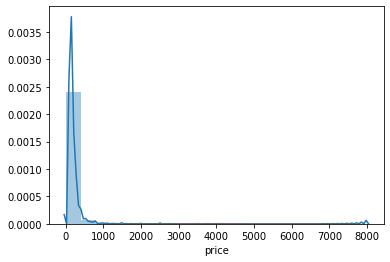

In [0]:
# Visualize distribution of prices
sns.distplot(airbnb['price'], bins = 20)
plt.show()

##### **Task 3:** Convert `listing_added` and `last_review` columns to `datetime`

To perform this task, we will use the following functions:

- `pd.to_datetime(format = "")`
  - `format` takes in the desired date format `"%Y-%m-%d"`

In [0]:
# Print header of two columns
airbnb[['listing_added', 'last_review']].head()

,listing_added,last_review
0,2018-06-08,2018-12-12
1,2018-12-25,2019-06-30
2,2018-08-15,NaN
3,2017-03-20,2017-09-23
4,2020-10-23,2019-06-12


In [0]:
# Convert both columns to datetime
airbnb['listing_added'] = pd.to_datetime(airbnb['listing_added'], format = '%Y-%m-%d')
airbnb['last_review'] = pd.to_datetime(airbnb['last_review'], format = '%Y-%m-%d')

In [0]:
# Print header and datatypes of both columns again
print(airbnb[['listing_added', 'last_review']].head())
print(airbnb[['listing_added', 'last_review']].dtypes)

  listing_added last_review
0    2018-06-08  2018-12-12
1    2018-12-25  2019-06-30
2    2018-08-15         NaT
3    2017-03-20  2017-09-23
4    2020-10-23  2019-06-12
listing_added    datetime64[ns]
last_review      datetime64[ns]
dtype: object


### Text and categorical data problems

##### **Task 4:** We need to collapse `room_type` into correct categories

To perform this task, we will be using the following methods:

- `.str.lower()` to lowercase all rows in a string column
- `.str.strip()` to remove all white spaces of each row in a string column
- `.replace()` to replace values in a column with another

In [0]:
# Print unique values of `room_type`
airbnb['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Private', 'Shared room',
       'PRIVATE ROOM', 'home', '   Shared room      '], dtype=object)

In [0]:
# Deal with capitalized values
airbnb['room_type'] = airbnb['room_type'].str.lower()
airbnb['room_type'].unique()

array(['private room', 'entire home/apt', 'private', 'shared room',
       'home', '   shared room      '], dtype=object)

In [0]:
# Deal with trailing spaces
airbnb['room_type'] = airbnb['room_type'].str.strip()
airbnb['room_type'].unique()

array(['private room', 'entire home/apt', 'private', 'shared room',
       'home'], dtype=object)

In [0]:
# Replace values to 'Shared room', 'Entire place', 'Private room' and 'Hotel room' (if applicable).
mappings = {'private room': 'Private Room', 
            'private': 'Private Room',
            'entire home/apt': 'Entire place',
            'shared room': 'Shared room',
            'home': 'Entire place'}

# Replace values and collapse data
airbnb['room_type'] = airbnb['room_type'].replace(mappings)
airbnb['room_type'].unique()

array(['Private Room', 'Entire place', 'Shared room'], dtype=object)

##### **Task 5:** Divide `neighbourhood_full` into 2 columns and making sure they are clean

In [0]:
# Print header of column
airbnb['neighbourhood_full'].head()

0           Brooklyn, Flatlands
1    Manhattan, Upper West Side
2    Brooklyn, Brooklyn Heights
3    Manhattan, Upper West Side
4    Manhattan, Lower East Side
Name: neighbourhood_full, dtype: object

In [0]:
# Split neighbourhood_full
borough_neighbourhood = airbnb['neighbourhood_full'].str.split(",", expand = True)
borough_neighbourhood.head()

,0,1
0,Brooklyn,Flatlands
1,Manhattan,Upper West Side
2,Brooklyn,Brooklyn Heights
3,Manhattan,Upper West Side
4,Manhattan,Lower East Side


In [0]:
# Create borough and neighbourhood columns
airbnb['borough'] = borough_neighbourhood[0]
airbnb['neighbourhood'] = borough_neighbourhood[1]
# Print header of columns
airbnb[['neighbourhood_full', 'borough', 'neighbourhood']].head()

,neighbourhood_full,borough,neighbourhood
0,"Brooklyn, Flatlands",Brooklyn,Flatlands
1,"Manhattan, Upper West Side",Manhattan,Upper West Side
2,"Brooklyn, Brooklyn Heights",Brooklyn,Brooklyn Heights
3,"Manhattan, Upper West Side",Manhattan,Upper West Side
4,"Manhattan, Lower East Side",Manhattan,Lower East Side


In [0]:
# Drop neighbourhood_full column
airbnb.drop('neighbourhood_full', axis = 1, inplace = True)

In [0]:
# Print out unique values of borough and neighbourhood
print(airbnb['borough'].unique())
print(airbnb['neighbourhood'].unique())

['Brooklyn' 'Manhattan' 'Queens' 'Bronx' 'Staten Island']
[' Flatlands' ' Upper West Side' ' Brooklyn Heights' ' Lower East Side'
 ' Greenwich Village' ' Harlem' ' Sheepshead Bay' ' Theater District'
 ' Bushwick' ' Laurelton' ' Mott Haven' ' Flushing' ' Crown Heights'
 ' Midtown' ' Financial District' ' East Village' ' Park Slope'
 ' Washington Heights' ' Williamsburg' ' Chelsea' ' Bedford-Stuyvesant'
 ' Gowanus' ' Upper East Side' ' Ditmars Steinway' ' Cypress Hills'
 " Hell's Kitchen" ' Ridgewood' ' Marble Hill' ' Kips Bay'
 ' Prospect Heights' ' East New York' ' Concord' ' Stapleton' ' Astoria'
 ' East Harlem' ' Sunnyside' ' Gramercy' ' Prospect-Lefferts Gardens'
 ' Sunset Park' ' Forest Hills' ' Windsor Terrace' ' Clinton Hill'
 ' Murray Hill' ' Flatiron District' ' Greenpoint' ' East Flatbush'
 ' Tribeca' ' Woodhaven' ' Fort Greene' ' Inwood' ' Chinatown'
 ' Rockaway Beach' ' Woodside' ' Bayside' ' Bensonhurst' ' SoHo'
 ' Red Hook' ' West Village' ' South Slope' ' Richmond Hill' '

In [0]:
# Strip white space from neighbourhood column
airbnb['neighbourhood'] = airbnb['neighbourhood'].str.strip()
# Print unique values again
print(airbnb['neighbourhood'].unique())

['Flatlands' 'Upper West Side' 'Brooklyn Heights' 'Lower East Side'
 'Greenwich Village' 'Harlem' 'Sheepshead Bay' 'Theater District'
 'Bushwick' 'Laurelton' 'Mott Haven' 'Flushing' 'Crown Heights' 'Midtown'
 'Financial District' 'East Village' 'Park Slope' 'Washington Heights'
 'Williamsburg' 'Chelsea' 'Bedford-Stuyvesant' 'Gowanus' 'Upper East Side'
 'Ditmars Steinway' 'Cypress Hills' "Hell's Kitchen" 'Ridgewood'
 'Marble Hill' 'Kips Bay' 'Prospect Heights' 'East New York' 'Concord'
 'Stapleton' 'Astoria' 'East Harlem' 'Sunnyside' 'Gramercy'
 'Prospect-Lefferts Gardens' 'Sunset Park' 'Forest Hills'
 'Windsor Terrace' 'Clinton Hill' 'Murray Hill' 'Flatiron District'
 'Greenpoint' 'East Flatbush' 'Tribeca' 'Woodhaven' 'Fort Greene' 'Inwood'
 'Chinatown' 'Rockaway Beach' 'Woodside' 'Bayside' 'Bensonhurst' 'SoHo'
 'Red Hook' 'West Village' 'South Slope' 'Richmond Hill' 'Jamaica'
 'Boerum Hill' 'St. George' 'Clason Point' 'College Point' 'Vinegar Hill'
 'Rego Park' 'East Elmhurst' 'Kensin

##### **Task 6:** Make sure we set the correct maximum for `rating` column out of range values

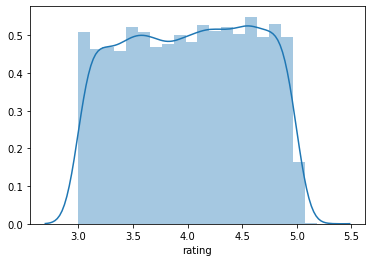

In [0]:
# Visualize the rating column again
sns.distplot(airbnb['rating'], bins = 20)
plt.show()

In [0]:
# Isolate rows of rating > 5.0
airbnb[airbnb['rating'] > 5.0]

,listing_id,name,host_id,host_name,room_type,price,number_of_reviews,last_review,reviews_per_month,availability_365,rating,number_of_stays,5_stars,listing_added,latitude,longitude,borough,neighbourhood
1925,36411407,Brand new 1 bedroom steps from Soho!,33917435,Mike,Entire place,150.0,1,2019-07-06,1.0,13,5.017040,1.2,0.870161,2018-12-31,40.71825,-73.99019,Manhattan,Lower East Side
6732,36390226,Comfortable clean Bedstuy private room,267932490,Angela,Private Room,45.0,2,2019-07-08,2.0,14,5.087091,2.4,0.950339,2019-01-02,40.69551,-73.93951,Brooklyn,Bedford-Stuyvesant
8821,36413632,Spacious 2BR in Beautiful Brooklyn Heights,6608220,Matt,Entire place,550.0,1,2019-07-07,1.0,230,5.181114,1.2,0.805418,2019-01-01,40.69827,-73.99649,Brooklyn,Brooklyn Heights


In [0]:
# Drop these rows and make sure we have effected changes
airbnb.drop(airbnb[airbnb['rating'] > 5.0].index, inplace = True)

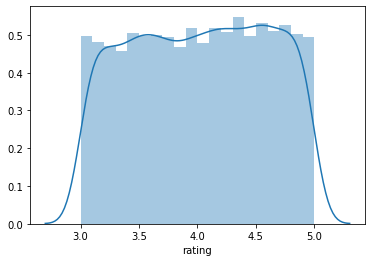

In [0]:
# Visualize the rating column again
sns.distplot(airbnb['rating'], bins = 20)
plt.show()

### Dealing with missing data

The `missingno` (imported as `msno`) package is great for visualizing missing data - we will be using:

- `msno.matrix()` visualizes a missingness matrix
- `msno.bar()` visualizes a missngness barplot
- `plt.show()` to show the plot

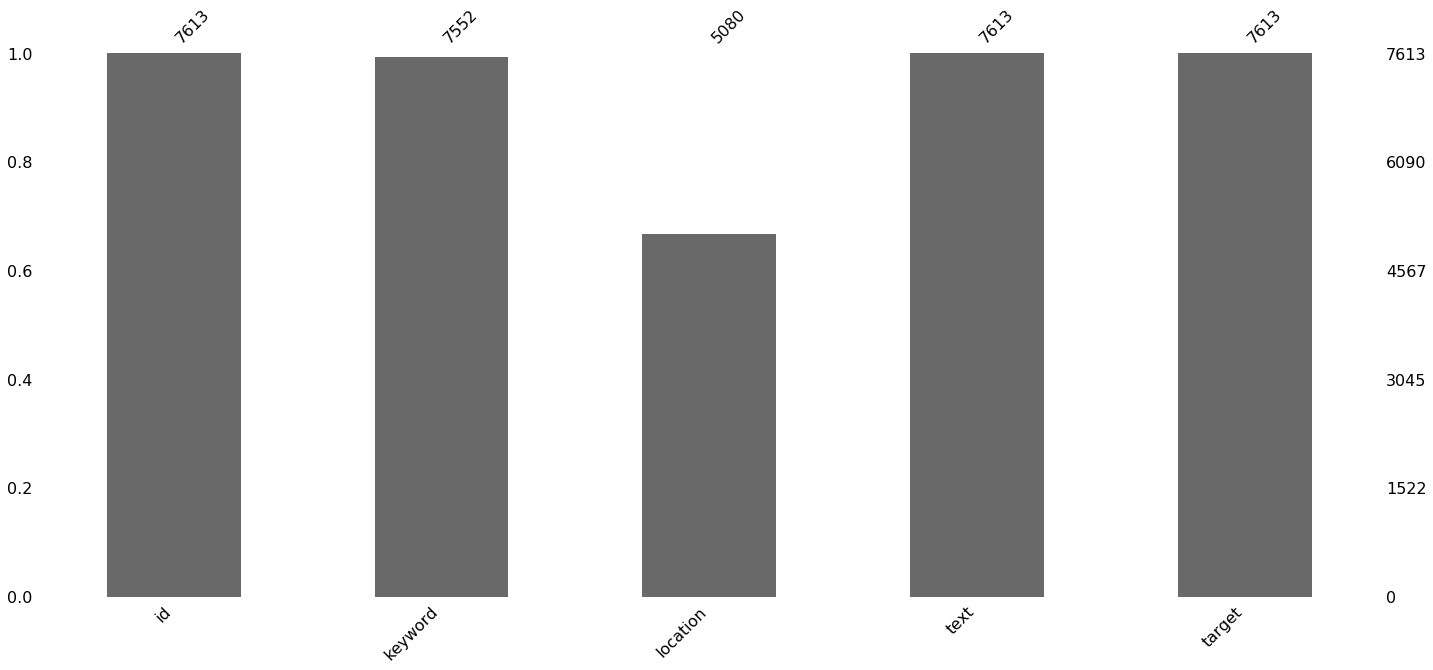

In [36]:
# Missingness for train set barplot
msno.bar(train)

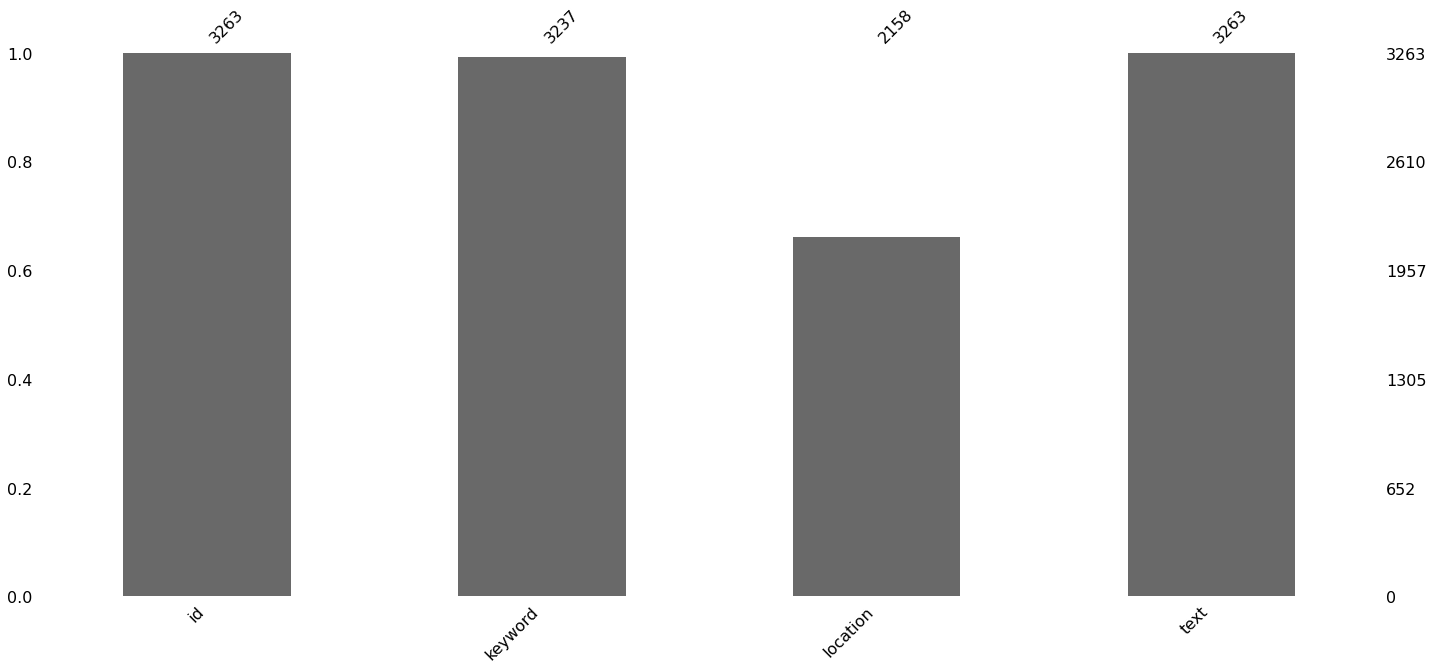

In [54]:
# Missingness for test set barplot
msno.bar(test)

In [37]:
print(f'Number of unique values in keyword = {train["keyword"].nunique()} (Training) - {test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {train["location"].nunique()} (Training) - {test["location"].nunique()} (Test)')

Number of unique values in keyword = 221 (Training) - 221 (Test)
Number of unique values in location = 3341 (Training) - 1602 (Test)


In [0]:
for df in [train, test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

Attributes are different for ___location___ in train and test sets. Thus, we prefer to eliminate it from training set.

Fortunately, there is signal in ___keyword___ because some of those words can only be used in one context. Keywords have very different tweet counts and target means. Keyword can be used as a feature by itself or as a word added to the text. Every single keyword in training set exists in test set. If training and test set are from the same sample, it is also possible to use target encoding on keyword.

In [99]:
train.keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [100]:
train.location.unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

### Target Field

When we look at target field, training set has approximately equal distribution of it. Therefore, we do not need to stratify or worry about any other balancing process.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014980CB1D48>]],
      dtype=object)

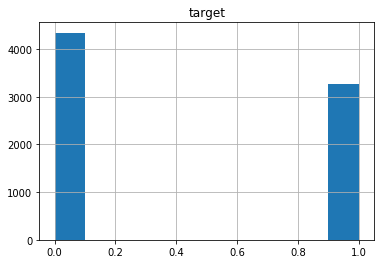

In [98]:
train.hist('target')

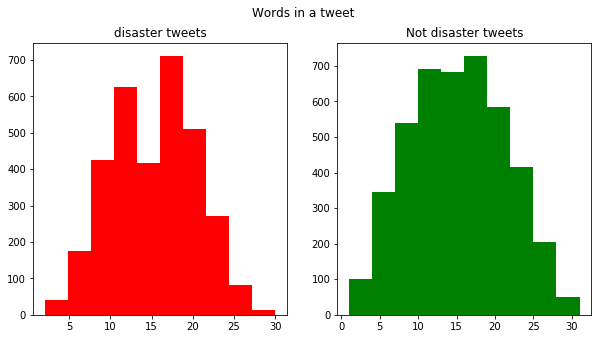

In [101]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

train_wordlen=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(train_wordlen,color='red')
ax1.set_title('disaster tweets')
train_wordlen=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(train_wordlen,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

From the histograms below, we see that disaster tweets are written with longer words compared to non-disaster. This feature can be used for the model.

Text(0.5, 0.98, 'Average word length in each tweet')

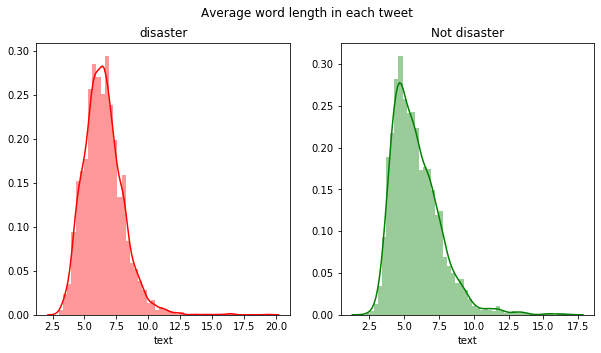

In [103]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

Looking at the missing data in the DataFrame - we can see that `number_of_reviews` across all missing rows is 0. We can infer that these listings have never been visited - hence could be inferred they're inactive/have never been visited. 

We can impute them as following:

- Set `NaN` for `reviews_per_month`, `number_of_stays`, `5_stars` to 0.
- Since a `rating` did not happen, let's keep the column as is - but create a new column named `rated` that takes in `1` if yes, `0` if no.
- We will also leave `last_review` as is.


In [91]:
train.head()

,id,keyword,location,text,target,mean_word_length,avg_wordlength
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,4.384615,"[3, 5, 3, 3, 6, 2, 4, 11, 3, 5, 7, 2, 3]"
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,4.571429,"[6, 4, 4, 2, 5, 5, 6]"
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,5.090909,"[3, 9, 5, 2, 8, 2, 6, 3, 5, 8, 2, 9, 2, 5, 10,..."
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,7.125000,"[6, 6, 7, 10, 10, 6, 2, 10]"
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,4.500000,"[4, 3, 4, 4, 5, 4, 4, 7, 2, 5, 4, 10, 5, 4, 1, 6]"


In [104]:
# Visualize relationship average word length and disaster
sns.boxplot(x = 'target', y = 'mean_word_length', data = train)
plt.ylim(0,20)
plt.xlabel('Target')
plt.ylabel('Avg Word Length')
plt.show()

ValueError: Could not interpret input 'mean_word_length'

#### **Task:** Let's check if there are any duplicate data

In [96]:
# Find duplicates in train set
duplicates = train.duplicated(subset="id", keep="first")
print("There are {} duplicate records in the test set.".format(train[duplicates].shape[0]))



There are 0 duplicate records in the test set.
